# Support Vector Machines

In [172]:
import numpy as np
import pickle as pkl
from scipy import optimize
from scipy.linalg import cho_factor, cho_solve
import matplotlib.pyplot as plt
from utils import plotClassification, plotRegression, plot_multiple_images, generateRings, scatter_label_points, loadMNIST

## Loading the data

The file 'classification_datasets' contains 3 small classification datasets:
    
    - dataset_1: mixture of two well separated gaussians
    - dataset_2: mixture of two gaussians that are not separeted
    - dataset_3: XOR dataset that is non-linearly separable.
   
Each dataset is a hierarchical dictionary with the following structure:
        
        dataset = {'train': {'x': data, 'y':label}
                    'test': {'x': data, 'y':label}
                  }
The data $x$ is an $N$ by $2$ matrix, while the label $y$ is a vector of size $N$. 

Only the third dateset is used. 

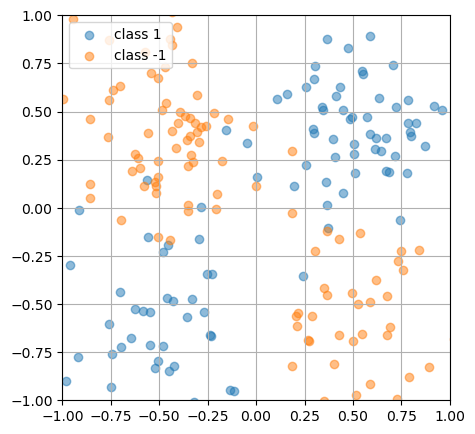

In [173]:
file = open('datasets/classification_datasets', 'rb')
datasets = pkl.load(file)
file.close()
dataset = datasets['dataset_3']

fig, ax = plt.subplots(1,1, figsize=(5, 5))
plotClassification(dataset['train']['x'], dataset['train']['y'], ax=ax)

In [174]:
dataset['train']['x'].shape

(200, 2)

## III- Kernel SVC 
### 1- Implementing the Gaussian Kernel
Implement the method 'kernel' of the class RBF below, which takes as input two data matrices $X$ and $Y$ of size $N\times d$ and $M\times d$ and returns a gramm matrix $G$ of shape $N\times M$ whose components are $k(x_i,y_j) = \exp(-\Vert x_i-y_j\Vert^2/(2\sigma^2))$. (The fastest solution does not use any for loop!)

In [194]:
class RBF:
    def __init__(self, sigma=1.):
        self.sigma = sigma  ## the variance of the kernel  

    def kernel(self, X, Y):
        ## Input vectors X and Y of shape Nxd and Mxd
        N, d = X.shape
        M, d_check = Y.shape
        if d != d_check:
            raise ValueError("Input vectors X and Y of shape Nxd1 and Mxd2 : d1 should be equal to d2")
        norm = -np.linalg.norm(X[:, np.newaxis, :] - Y[np.newaxis, :, :], axis=-1)
        return np.exp(norm**2 / (2*self.sigma**2)) ## Matrix of shape NxM

class Linear:
    def kernel(self, X, Y):
        # Input vectors X and Y of shape Nxd and Mxd
        return X @ Y.T


### 2- Implementing the classifier
Implement the methods 'fit' and 'separating_function' of the class KernelSVC below to learn the Kernel Support Vector Classifier.

In [258]:
class KernelSVC:
    
    def __init__(self, C, kernel, epsilon = 1e-3):
        self.type = 'non-linear'
        self.C = C                               
        self.kernel = kernel        
        self.alpha = None
        self.support = None
        self.epsilon = epsilon
        self.norm_f = None
       
    
    def fit(self, X, y):
        #### You might define here any variable needed for the rest of the code
        N = len(y)
        K = self.kernel(X, X) * np.outer(y, y)

        # Lagrange dual problem
        def loss(alpha):
            return np.dot(alpha.T, np.dot(K, alpha)) - 2 * np.sum(alpha) #'''--------------dual loss ------------------ '''

        # Partial derivate of Ld on alpha
        def grad_loss(alpha):
            return  2*np.dot(K, alpha) - 2*np.ones(N) # '''----------------partial derivative of the dual loss wrt alpha -----------------'''

        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0

        fun_eq = lambda alpha: np.dot(y, alpha) # '''----------------function defining the equality constraint------------------'''        
        
        jac_eq = lambda alpha: y #'''----------------jacobian wrt alpha of the  equality constraint------------------'''
        
        fun_ineq = lambda alpha: self.C - alpha # '''---------------function defining the inequality constraint-------------------'''     
        fun_ineq2 = lambda alpha: alpha

        jac_ineq = lambda alpha: -np.eye(N) # '''---------------jacobian wrt alpha of the  inequality constraint-------------------'''
        jac_ineq2 = lambda alpha: np.eye(N)
        
        constraints = ({'type': 'eq',  'fun': fun_eq, 'jac': jac_eq},
                       {'type': 'ineq', 
                        'fun': fun_ineq, 
                        'jac': jac_ineq}, 
                        {'type': 'ineq', 
                        'fun': fun_ineq2, 
                        'jac': jac_ineq2})

        optRes = optimize.minimize(fun=lambda alpha: loss(alpha),
                                   x0=np.ones(N), 
                                   method='SLSQP', 
                                   jac=lambda alpha: grad_loss(alpha),
                                   constraints=constraints)
        self.alpha = optRes.x
        
        ## Assign the required attributes
        A = self.alpha * y

        margin_points_indexes = (self.alpha > self.epsilon) & (self.alpha < self.C + self.epsilon)
        self.margin_points = X[margin_points_indexes]#'''------------------- A matrix with each row corresponding to a point that falls on the margin ------------------'''
        self.A_support = A[margin_points_indexes]

        margins = np.sum(self.A_support[:, np.newaxis] * self.kernel(self.margin_points, self.margin_points), axis=0)
        self.b = np.mean(y[margin_points_indexes] - margins)#''' -----------------offset of the classifier------------------ '''

        self.norm_f = np.sqrt(np.dot(np.dot(A.T, self.kernel(X, X)), A)) #'''------------------------RKHS norm of the function f ------------------------------'''


        self.support = self.margin_points #'''------------------- A matrix with each row corresponding to a point that falls on the margin ------------------'''

    ### Implementation of the separting function $f$ 
    def separating_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        return np.sum(self.A_support[:, np.newaxis] * self.kernel(self.margin_points, x), axis=0)
    
    
    def predict(self, X):
        """ Predict y values in {-1, 1} """
        d = self.separating_function(X)
        return 2 * (d+self.b> 0) - 1

### 2- Fitting the classifier

Run the code block below to fit the classifier and report its output.

Number of support vectors = 42


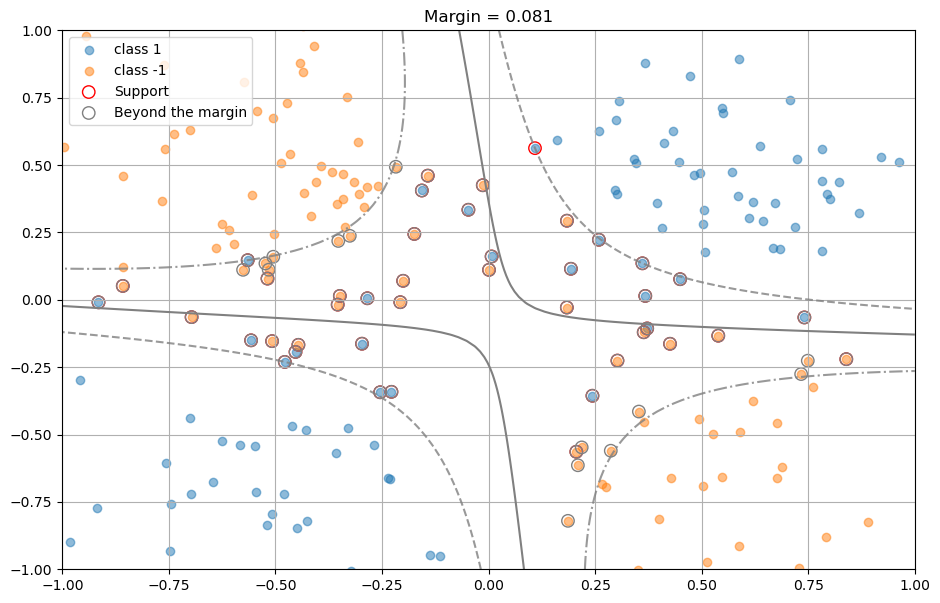

In [259]:
sigma = 1.5
C=100.
kernel = RBF(sigma).kernel
model = KernelSVC(C=C, kernel=kernel)
train_dataset = datasets['dataset_3']['train']
model.fit(train_dataset['x'], train_dataset['y'])
plotClassification(train_dataset['x'], train_dataset['y'], model, label='Training')